## 1) Load the images and labels

In [1]:
import numpy as np
from collections import Counter
from sklearn import svm, metrics
import pickle as pkl

from src.utils import load_data, display_n_images, create_SIFT_features, cluster_descriptors, convert_des_to_hist

In [2]:
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
# from utils import load_data

import torch as T
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import Sequential 
from torch.utils.data import DataLoader, TensorDataset, random_split
# import torchmetrics accuracy
import torchmetrics

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger

from torchvision.datasets import MNIST
from torchvision import transforms

from sklearn.metrics import classification_report, confusion_matrix

c:\ProgramData\Anaconda3\envs\fer\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
PATH_TRAIN_IMG = '../CW_Dataset/train/'
PATH_TEST_IMG = '../CW_Dataset/test/'
PATH_TRAIN_LABEL = '../CW_Dataset/labels/list_label_train.txt'
PATH_TEST_LABEL = '../CW_Dataset/labels/list_label_test.txt'

In [4]:
X_train_list, y_train_list = load_data(PATH_TRAIN_IMG, PATH_TRAIN_LABEL, gray=True)
X_test_list, y_test_list = load_data(PATH_TEST_IMG, PATH_TEST_LABEL, gray=True)

In [5]:
# sample for testing
X_train_list = X_train_list[:1000]
y_train_list = y_train_list[:1000]
X_test_list = X_test_list[:1000]
y_test_list = y_test_list[:1000]
PRINT = True

In [6]:
Counter(y_train_list)
#display_n_images(X_train_list, y_train_list, 20)

Counter({5: 217, 4: 513, 1: 144, 6: 87, 2: 3, 3: 36})

In [7]:
# convert to tensors
X_train = T.tensor(np.array(X_train_list), dtype=T.float)  # image should be float
y_train = T.tensor(np.array(y_train_list), dtype=T.long) - 1  # target should be long | -1 to make 0-6 range
X_test = T.tensor(np.array(X_test_list), dtype=T.float)
y_test = T.tensor(np.array(y_test_list), dtype=T.long) - 1

# Add channel dimension | image size: (channel, height, width)
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# convert to tensor dataset (train, val, test)
train_dataset = TensorDataset(X_train, y_train)
val_split = int(0.25 * len(train_dataset))
train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - val_split, val_split])
test_dataset = TensorDataset(X_test, y_test)

# create data loaders (train, val, test) | image size: (batch, channel, height, width)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

In [8]:
print('Train obs: {} - Val obs: {} - Test obs: {}'.format(len(train_dataset), len(val_dataset), len(test_dataset)))
print('\nLabel:', train_dataset[0][1])

print('\nImage shape:', train_dataset[0][0].shape)  # dimensions first dataset item

batch_x, batch_y = next(iter(train_loader))  # dimensions first data loader batch
print('\nBatch shape:', batch_x.shape)

Train obs: 750 - Val obs: 250 - Test obs: 1000

Label: tensor(4)

Image shape: torch.Size([1, 100, 100])

Batch shape: torch.Size([64, 1, 100, 100])


### 2) Train CNN

In [9]:
class LitCNN(LightningModule):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.input_size = input_size
        
        # CNN block - image size 100*100
        self.CNN_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # FC block - image batch size: torch.Size([32, 128, 12, 12])
        self.FC_layers = nn.Sequential(
            nn.Linear(in_features=128 * 12 * 12, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes),
        )

    def forward(self, x):
        x = self.CNN_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.FC_layers(x)  # no activation and no softmax at the end
        return x  

    def configure_optimizers(self):
        optimizer = T.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.log('train_loss', loss, prog_bar=True, on_step=True)
        self.log('train_acc', self.accuracy(y_hat, y), prog_bar=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.log('val_loss', loss, prog_bar=True, on_step=True)
        self.log('val_acc', self.accuracy(y_hat, y), prog_bar=True, on_step=True)
        return loss

    # def validation_epoch_end(self, outputs):
    #     avg_loss = T.stack([x['val_loss'] for x in outputs]).mean()
    #     tensorboard_logs = {'val_loss': avg_loss}
    #     return {'val_loss': avg_loss, 'log': tensorboard_logs}

In [17]:
# Check if GPU is available
if T.cuda.is_available():
    device = T.device('cuda')
else:
    device = T.device('cpu')

In [10]:
# model
model = LitCNN(input_size=100*100, num_classes=7)
model.to(device)

# Move data to GPU
train_loader.to(device)
val_loader.to(device)

In [18]:
# training
logger = TensorBoardLogger('../tensorboard_logs', 'my_model')
trainer = pl.Trainer(logger=logger, max_epochs=2, fast_dev_run=False, gpus=1 if device.type == 'cuda' else 0)

c:\ProgramData\Anaconda3\envs\fer\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | accuracy   | MulticlassAccuracy | 0     
1 | CNN_layers | Sequential         | 92.7 K
2 | FC_layers  | Sequential         | 2.4 M 
--------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.812     Total estimated model params size (MB)


c:\ProgramData\Anaconda3\envs\fer\lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s, loss=1.4, v_num=3, train_loss=1.160, train_acc=0.565, val_loss_step=1.620, val_acc_step=0.448, val_loss_epoch=1.450, val_acc_epoch=0.460] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s, loss=1.4, v_num=3, train_loss=1.160, train_acc=0.565, val_loss_step=1.620, val_acc_step=0.448, val_loss_epoch=1.450, val_acc_epoch=0.460]


In [20]:
%load_ext tensorboard
%tensorboard --logdir ../tensorboard_logs

Reusing TensorBoard on port 6006 (pid 9968), started 0:03:11 ago. (Use '!kill 9968' to kill it.)

In [25]:
# test
y_hat = model(X_test)
y_hat = y_hat.argmax(dim=1)
y_hat = y_hat.detach().numpy()

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       145
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        27
           3       0.64      1.00      0.78       640
           4       0.57      0.03      0.05       140
           5       0.00      0.00      0.00        44

    accuracy                           0.64      1000
   macro avg       0.20      0.17      0.14      1000
weighted avg       0.49      0.64      0.51      1000



c:\ProgramData\Anaconda3\envs\fer\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\fer\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\fer\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

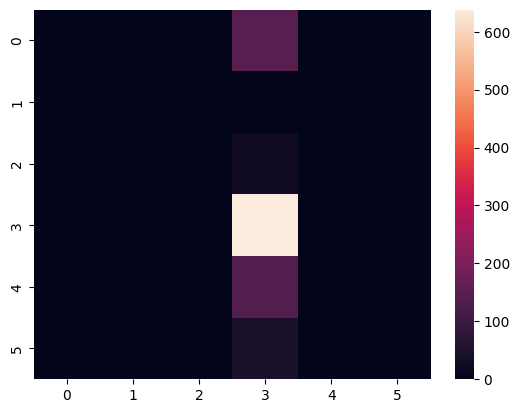

In [26]:
# classification report
print(classification_report(y_test, y_hat))
sns.heatmap(confusion_matrix(y_test, y_hat))